# Sentiment Analysis on IMDB Movie Reviews

### Import the Libraries

In [120]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the IMDB Movie Reviews dataset
Loading the [IMDB Reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) dataset via [Tensorflow Datasets](https://www.tensorflow.org/datasets), a collection of prepared datasets for machine learning.

In [123]:
imdb = tfds.load("imdb_reviews", as_supervised=True)

In [124]:
print(imdb)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [125]:
# View 2 training examples
for example in imdb['train'].take(2):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

### Prepare the dataset

In [129]:
train_dataset, test_dataset = imdb['train'], imdb['test']

In [131]:
# Parameters
VOCAB_SIZE = 10000
MAX_LENGTH = 120
EMBEDDING_DIM = 16
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [134]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)
train_labels = train_dataset.map(lambda review, label: label)

# Get the string inputs and integer outputs of the test set
test_reviews = test_dataset.map(lambda review, label: review)
test_labels = test_dataset.map(lambda review, label: label)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

In [135]:
for element in train_reviews.take(1):  # Shows the first 5 elements
    print(element.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [136]:
def padding_func(sequences):

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [137]:
# Apply the layer to the train and test data
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

In [138]:
for example in train_sequences.take(2):
  print(example)

tf.Tensor(
[   0    0    0    0   11   14   34  412  384   18   90   28    1    8
   33 1322 3560   42  487    1  191   24   85  152   19   11  217  316
   28   65  240  214    8  489   54   65   85  112   96   22 5596   11
   93  642  743   11   18    7   34  394 9522  170 2464  408    2   88
 1216  137   66  144   51    2    1 7558   66  245   65 2870   16    1
 2860    1    1 1426 5050    3   40    1 1579   17 3560   14  158   19
    4 1216  891 8040    8    4   18   12   14 4059    5   99  146 1241
   10  237  704   12   48   24   93   39   11 7339  152   39 1322    1
   50  398   10   96 1155  851  141    9], shape=(120,), dtype=int32)
tf.Tensor(
[   0    0    0    0    0    0    0    0   10   26   75  617    6  776
 2355  299   95   19   11    7  604  662    6    4 2129    5  180  571
   63 1403  107 2410    3 3905   21    2    1    3  252   41 4781    4
  169  186   21   11 4259   10 1507 2355   80    2   20   14 1973    2
  114  943   14 1740 1300  594    3  356  180  446    6 

In [139]:
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences,test_labels)

In [140]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,   10,

In [141]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

### Plot Utility

In [143]:
def plot_loss_acc(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'r', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

### Build and Compile the Model

#### Model 1: Flatten

In [146]:
# Parameters
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          11,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
NUM_EPOCHS = 10

# Train the model
history_flatten = model_flatten.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6313 - loss: 0.6127 - val_accuracy: 0.8163 - val_loss: 0.3989
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8778 - loss: 0.2939 - val_accuracy: 0.8087 - val_loss: 0.4361
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9540 - loss: 0.1414 - val_accuracy: 0.8057 - val_loss: 0.5252
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9932 - loss: 0.0382 - val_accuracy: 0.8054 - val_loss: 0.6074
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9990 - loss: 0.0089 - val_accuracy: 0.8054 - val_loss: 0.6813
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.8052 - val_loss: 0.7412
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8067 - val_loss: 0.7873
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 1.0000 - loss: 5.2723e-04 - 

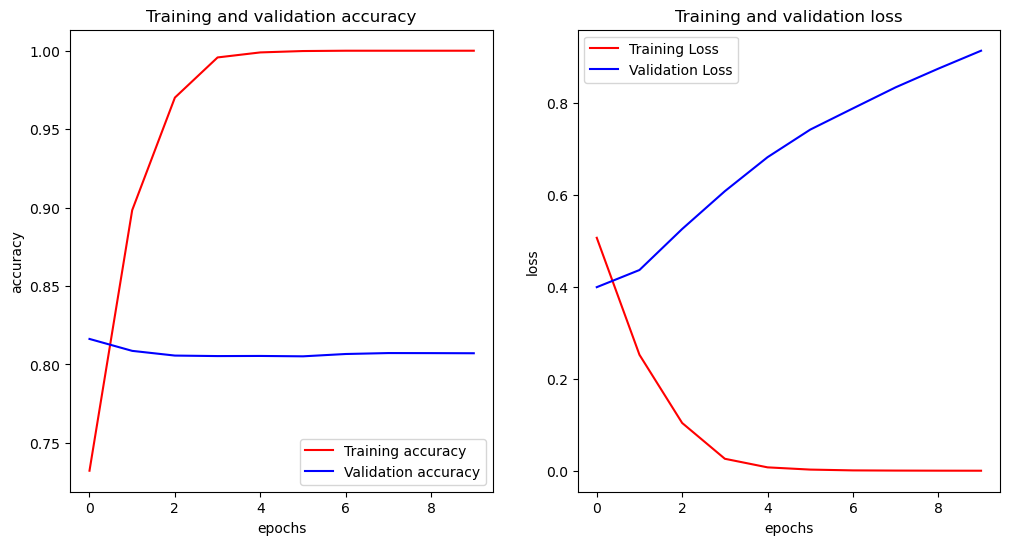

In [148]:
plot_loss_acc(history_flatten)

#### Model 2: LSTM
This is slower to train but useful in applications where the order of the tokens is important.

In [150]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.6460 - loss: 0.5934 - val_accuracy: 0.8087 - val_loss: 0.4277
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8654 - loss: 0.3233 - val_accuracy: 0.8036 - val_loss: 0.4412
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.9006 - loss: 0.2546 - val_accuracy: 0.8144 - val_loss: 0.4677
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.9229 - loss: 0.2040 - val_accuracy: 0.8090 - val_loss: 0.5242
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9410 - loss: 0.1577 - val_accuracy: 0.8053 - val_loss: 0.5918
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 93ms/step - accuracy: 0.9609 - loss: 0.1119 - val_accuracy: 0.8014 - val_loss: 0.7160
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.9744 - loss: 0.0762 - val_accuracy: 0.7997 - val_loss: 0.8774
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.9786 - loss: 0.0618 - 

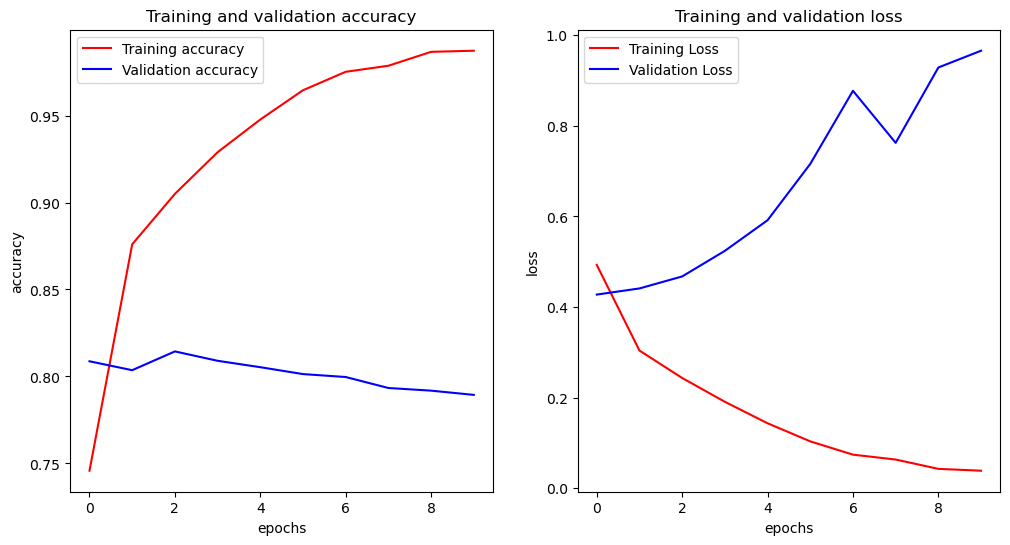

In [152]:
plot_loss_acc(history_lstm)

#### Model 3: GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [154]:
# Parameters
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
NUM_EPOCHS = 10

# Train the model
history_gru = model_gru.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 111ms/step - accuracy: 0.6023 - loss: 0.6296 - val_accuracy: 0.8164 - val_loss: 0.4287
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step - accuracy: 0.8493 - loss: 0.3551 - val_accuracy: 0.8128 - val_loss: 0.4225
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 109ms/step - accuracy: 0.8951 - loss: 0.2670 - val_accuracy: 0.8188 - val_loss: 0.4436
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - accuracy: 0.9248 - loss: 0.2025 - val_accuracy: 0.8099 - val_loss: 0.5074
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 109ms/step - accuracy: 0.9467 - loss: 0.1467 - val_accuracy: 0.8040 - val_loss: 0.5894
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 109ms/step - accuracy: 0.9647 - loss: 0.1058 - val_accuracy: 0.7995 - val_loss: 0.7092
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - accuracy: 0.9747 - loss: 0.0737 - val_accuracy: 0.7956 - val_loss: 0.8503
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 108ms/step - accuracy: 0.9828 - loss: 0

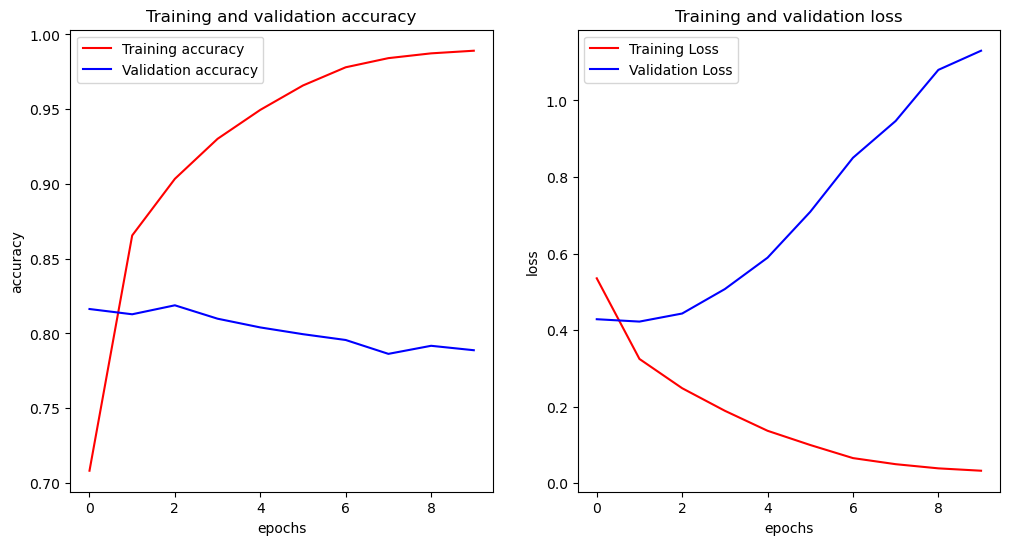

In [156]:
# Plot the accuracy and loss history
plot_loss_acc(history_gru)

#### Model 4: Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [158]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 116, 128)            │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6649 - loss: 0.6037 - val_accuracy: 0.8203 - val_loss: 0.4633
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8697 - loss: 0.3908 - val_accuracy: 0.8252 - val_loss: 0.4358
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9002 - loss: 0.3028 - val_accuracy: 0.8186 - val_loss: 0.4361
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9196 - loss: 0.2470 - val_accuracy: 0.8118 - val_loss: 0.4789
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9382 - loss: 0.2030 - val_accuracy: 0.8079 - val_loss: 0.5696
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9527 - loss: 0.1678 - val_accuracy: 0.8056 - val_loss: 0.6766
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9629 - loss: 0.1379 - val_accuracy: 0.8024 - val_loss: 0.7313
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9686 - loss: 0.1217 - 

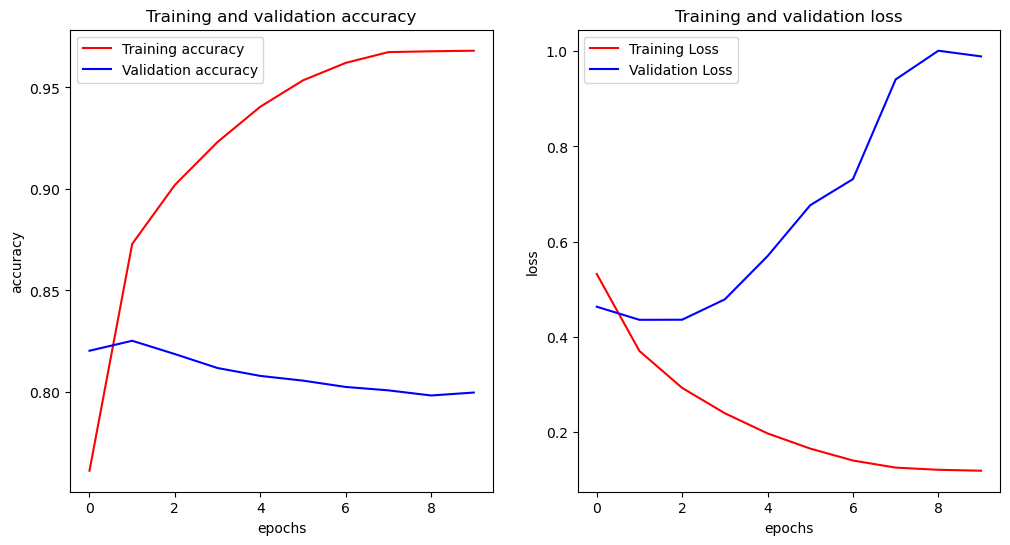

In [160]:
# Plot the accuracy and loss history
plot_loss_acc(history_conv)